In [2]:
import fiona
import geopandas as gpd
import pandas as pd
import sys
sys.path.append('../')

# Exploration of the GHSL Urban Centre Database

Experimental notebook to test procedure that collects city boundaries from the GHSL data and city lists

## 1. Intializing the GeoDataFrame

In [3]:
from src.vars import ghsl_crs
raw_data_path = '../data/d1_raw/urban-centre-database/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg'

In [17]:
gdf = gpd.read_file(raw_data_path, to_crs=ghsl_crs)

<AxesSubplot:>

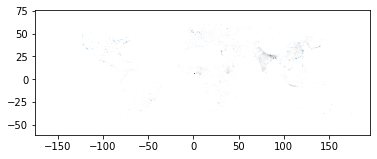

In [18]:
gdf.plot()

In [3]:
with fiona.open(raw_data_path, 'r') as fiona_collection:
    # Create GeoDataFrame from Fiona Collection
    gdf = gpd.GeoDataFrame.from_features([feature for feature in fiona_collection], crs=ghsl_crs)
    # Get the order of the fields in the Fiona Collection; add geometry to the end
    columns = list(fiona_collection.meta["schema"]["properties"]) + ["geometry"]
    # Re-order columns in the correct order
    gdf = gdf[columns]

## 2. Cleaning the GeoDataFrame

Now that we have the GeoDataFrame, we collect some summary statistics. More documentation can be found in the GHSL official dataset description

In [10]:
print("There are", len(gdf), "urban centers in the dataset")
print("There are", len(list(gdf.columns)), "columns per urban center")

There are 13135 urban centers in the dataset
There are 161 columns per urban center


There are obviously too many variables per urban center. For example, a full row has the following values:

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(gdf.iloc[2021])

ID_HDC_G0                                                 2022.0
QA2_1V                                                       1.0
AREA                                                        31.0
BBX_LATMN                                              48.419784
BBX_LONMN                                               1.443075
BBX_LATMX                                              48.476418
BBX_LONMX                                               1.533985
GCPNT_LAT                                              48.442465
GCPNT_LON                                               1.485679
CTR_MN_NM                                                 France
CTR_MN_ISO                                                   FRA
XBRDR                                                        0.0
XCTR_NBR                                                     1.0
XC_NM_LST                                                 France
XC_ISO_LST                                                   FRA
GRGN_L1                  

Upon reading the documentation, we choose to focus on a few of the columns for inspection in the project. Those will have information regarding:

- The urban centre name ('urban centre'), and the country ('country') it is majoritarily located
- The list of cities composing that urban centre, separated by ; ('cities')
- The subcontinent where the city is majoritarily located ('subcontinent')
- The population of the city in 2015 ('population')
- The area of the city in 2015 ('area')

Besides, of course, multipolygons that represent the city administrative boundary

In [19]:
clean_gdf = gdf[['UC_NM_MN', 'UC_NM_LST', 'CTR_MN_NM', 'GRGN_L1', 'GRGN_L2', 'P15', 'AREA', 'geometry']]
processed_gdf = clean_gdf.rename({'UC_NM_MN':'urban centre',
                                  'UC_NM_LST':'cities',
                                  'CTR_MN_NM':'country',
                                  'GRGN_L1': 'continent',
                                  'GRGN_L2':'subcontinent',
                                  'P15':'population',
                                  'AREA':'area'},
                                  axis='columns')
processed_gdf.sample(n=5)

,urban centre,cities,country,continent,subcontinent,population,area,geometry
5116,Khasavyurt,Khasavyurt,Russia,Europe,Eastern Europe,174191.652252,37.0,"MULTIPOLYGON (((46.57290 43.28344, 46.60937 43..."
5661,Walakhere,Walakhere,Ethiopia,Africa,Eastern Africa,95110.375000,1.0,"MULTIPOLYGON (((43.53109 5.80267, 43.54109 5.8..."
1391,Cachoeiro de Itapemirim,Cachoeiro de Itapemirim,Brazil,Latin America and the Caribbean,South America,154094.316650,30.0,"MULTIPOLYGON (((-41.18614 -20.82420, -41.17574..."
8331,Virudhunagar,Virudhunagar,India,Asia,South-Central Asia,132266.002563,15.0,"MULTIPOLYGON (((77.94458 9.60926, 77.96471 9.6..."
10301,Yun,Yun,China,Asia,Eastern Asia,66818.347412,15.0,"MULTIPOLYGON (((100.14145 24.46871, 100.17318 ..."


## 3. Sampling the GeoDataFrame

Our end goal is to use all the 1,315 cities, but we must first design a suitable experiment for a subset of those cities. Sampling the dataframe should ideally produce a representative sample across cities of different continents and different size. The counts of urban centres per (sub)continent are:

In [13]:
processed_gdf['subcontinent'].value_counts()

South-Central Asia       4272
Eastern Asia             2111
Eastern Africa           1050
South-Eastern Asia        875
Western Africa            804
South America             736
Northern Africa           512
Western Asia              479
Eastern Europe            420
Northern America          372
Middle Africa             350
Central America           266
Southern Europe           230
Western Europe            227
Northern Europe           182
Southern Africa            89
Caribbean                  74
Melanesia                  50
Australia/New Zealand      35
Polynesia                   1
Name: subcontinent, dtype: int64

In [14]:
processed_gdf['continent'].value_counts()

Asia                               7737
Africa                             2805
Latin America and the Caribbean    1076
Europe                             1059
Northern America                    372
Oceania                              86
Name: continent, dtype: int64

We will use a sample that preserves representatives for each subcontinent. To avoid issues, we will drop the polynesia group since it contains a single center:

In [16]:
sampled_gdf = processed_gdf[processed_gdf['subcontinent'] != 'Polynesia'].groupby('subcontinent').sample(n=10).reset_index()
sampled_gdf['subcontinent'].value_counts()

Australia/New Zealand    10
Northern Europe          10
Western Asia             10
Western Africa           10
Southern Europe          10
Southern Africa          10
South-Eastern Asia       10
South-Central Asia       10
South America            10
Northern America         10
Caribbean                10
Northern Africa          10
Middle Africa            10
Melanesia                10
Eastern Europe           10
Eastern Asia             10
Eastern Africa           10
Central America          10
Western Europe           10
Name: subcontinent, dtype: int64

## 4. Testing the Process

Repeat the test pipeline to use the fucntions from the src module to obtain the boundaries:

In [ ]:
import sys
sys.path.append('../')

from src import get_cities as gc
from src import get_boundary as gb

ghsl_gdf = gc.get_processed_urbancentre_gdf(sample=True)
boundaries_dict = gb.get_boundaries(method='GHSL', ghsl_gdf=ghsl_gdf, test=False)